Fits for number of data points:1000
Predicts and computes accuracy for the test set
Fits for number of data points:10000
Predicts and computes accuracy for the test set
Fits for number of data points:20000
Predicts and computes accuracy for the test set
Fits for number of data points:35000
Predicts and computes accuracy for the test set
Fits for number of data points:42500
Predicts and computes accuracy for the test set


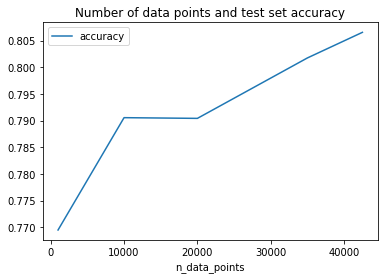

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import pipeline
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from utils import get_reviews, results
import pandas as pd
import numpy as np

    
def make_sklearn():
    return MLPClassifier(
            batch_size=100, hidden_layer_sizes=(64, 64),
            solver='adam', verbose=False, max_iter=400)

shape = (50000, 250, 768)
df = get_reviews()
X_repr = np.memmap(f'bert_features_shape_{shape}.dat',
                   dtype='float16', mode='r+',shape=shape)
X_repr = X_repr[:, 0, :]

(
    pd.DataFrame(results(
        df,
        make_model=make_sklearn,
        n_data_points=[1000, 10000, 20000, 35000, int(len(df)*0.85)],
        #n_data_points=[100, 500, len(df)],
        batch_size_inference=1024,
        test_size=0.15,
        X_representation=X_repr
    ))
    .set_index('n_data_points')
    .plot(title='Number of data points and test set accuracy')
);